<div>
  <h3>k-fold cross-validation</h3>
  <ul>
    <li>Impartim setul de date in k sub-seturi</li>
    <li>Apoi
      <ul>
        <li>Iteram de k ori</li>
        <li>luam k-1 seturi ca set de training</li>
        <li>restul de 1 setul de validare</li>
        <li>antrenam regresorul</li>
        <li>lil_err = ...</li>
      </ul>
    </li>
    <li>err = Suma de li_err</li>
  </ul>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_2035/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
def read_data(filePath: str):
    df = pd.read_csv(filePath)
    df = df.dropna()
    return df

def splitDatasInKFolds(filePath:str, k:int):
    df = read_data(filePath)
    size = df.shape[0]
    arr = np.array_split(range(size),k)
    input_sets = [[df["Economy..GDP.per.Capita."].iloc[index] for index in indexes ] for indexes in arr]
    output_sets = [[df["Happiness.Score"].iloc[index] for index in indexes ] for indexes in arr]
    return input_sets, output_sets

def getErrors(computedOutputValues, groundTruthValues):
    err = 0.0
    for cov,gtv in zip(computedOutputValues, groundTruthValues):
        err = (gtv - cov)**2
    err /= len(computedOutputValues)
    return err

from sklearn.linear_model import SGDRegressor
def getAndTrainReggressor(filePath:str, k:int):
    input_sets,output_sets = splitDatasInKFolds(filePath, k)
    regressor = SGDRegressor()
    errors = []
    for i in range(k):
        validation_input_set, validation_output_set = input_sets[i],output_sets[i]
        training_input_set = []
        training_output_set = []
        for j in range(k):
            if j != i:
                training_input_set += input_sets[j]
                training_output_set += output_sets[j]
        
        xx = [[el] for el in training_input_set]
        regressor.partial_fit(xx, training_output_set)    
        
        xx_test = [[el] for el in validation_input_set]
        computed_output_values = regressor.predict(xx_test)

        errors.append(getErrors(computed_output_values, validation_output_set))
    
    return regressor, errors

In [6]:
def plotToolRegressor(filePath:str, k:int):

    df = read_data(filePath)

    input_sets = df["Economy..GDP.per.Capita."]
    output_sets = df["Happiness.Score"]

    regressor, err = getAndTrainReggressor(filePath, k)
    w0, w1 = regressor.intercept_, regressor.coef_[0]

    print("f(x) = {} + {}*x".format(w0,w1))

    print("Eroare: {}".format(err))

    noOfPoints = 1000
    xref = []
    val = min(input_sets)
    step = (max(input_sets) - min(input_sets)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1 * el for el in xref] 

    fix,axes = plt.subplots()

    axes.plot(input_sets, output_sets, 'ro', label = 'training data')  
    axes.plot(xref, yref, 'b-', label = 'learnt model')                  
    axes.set_title('train data and the learnt model')
    axes.set_xlabel('GDP')
    axes.set_ylabel('happiness')
    axes.legend()
    plt.show()


f(x) = [2.76006739] + 2.595936573776451*x
Eroare: [0.2822902698549046, 0.18588767952948265, 0.03922189671341408, 0.02009968247071872, 0.031217324939612018, 0.015314783166675077, 0.027112265731915837, 0.0015215325908500168, 0.00026458967405841816]


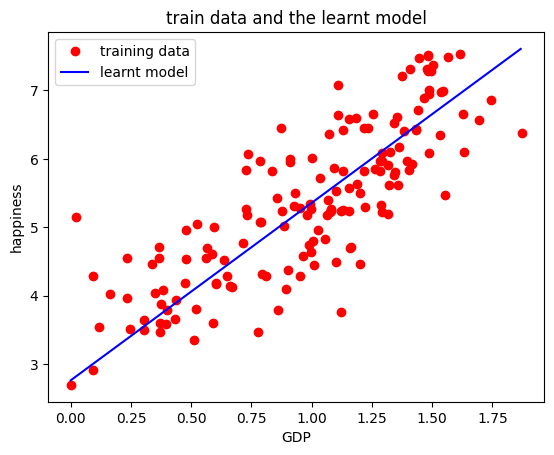

In [9]:
plotToolRegressor('datas/2017.csv',9)

<div>
  <h3>Validare încrucișată leave-one-out (LOOCV)</h3>
  <ul>
    <li>Subcaz al lui k-fold cross validation unde k = numarul de inregistrari</li>
    <li>Apoi
      <ul>
        <li>Iteram de k ori</li>
        <li>luam k-1 seturi ca set de training</li>
        <li>restul de 1 setul de validare</li>
        <li>antrenam regresorul</li>
        <li>lil_err = ...</li>
      </ul>
    </li>
    <li>err = Suma de li_err</li>
  </ul>
</div>

<ol>
<li>Mean Squared Error (MSE):
    <ul>
        <li>Funcția de pierdere clasică pentru problemele de regresie.</li>
        <li>Calculează media pătratelor diferențelor între predicțiile modelului și valorile țintă.</li>
        <li>Este sensibilă la valori extreme și poate fi afectată de outliere.</li>
    </ul>
</li>
<li>Binary Cross-Entropy (Log Loss):
    <ul>
        <li>Folosită în probleme de clasificare binară, unde țintele sunt etichete binare (0 sau 1).</li>
        <li>Măsoară discrepanța între distribuția de probabilitate prezisă de model și distribuția reală a claselor.</li>
        <li>Este o funcție convexă și este comun utilizată în combinație cu funcția sigmoid pentru a obține probabilități între 0 și 1</li>
    </ul>
</li>
<li>Categorical Cross-Entropy:
    <ul>
        <li>Similar cu binary cross-entropy, dar pentru probleme de clasificare cu mai multe clase.</li>
        <li>Este utilizată atunci când etichetele sunt reprezentate ca variabile categoriale.</li>
        <li>Măsoară discrepanța între distribuția de probabilitate a claselor prezise și distribuția reală a claselor.</li>
    </ul>
</li>
<li>Hinge Loss:
    <ul>
        <li>Utilizată în special în problemele de clasificare cu suport vectorial (SVM).</li>
        <li>Măsoară marginea (marginea dintre clasa corectă și celelalte clase) și penalizează predicțiile greșite care sunt aproape de margine.</li>
    </ul>
</li>
<li>Huber Loss:
    <ul>
        <li>O alternativă la mean squared error care este mai robustă la valori extreme și la outliere.</li>
        <li>Se comportă ca MSE în jurul originii și ca MAE în alte zone.</li>
    </ul>
</li>
<li>Kullback-Leibler Divergence (KL Divergence):
    <ul>
        <li>Măsoară diferența dintre două distribuții de probabilitate.</li>
        <li>Este adesea folosită în problemele de regresie și clasificare, în special în învățarea automată generativă.</li>
    </ul>
</li>
</ol>

<div style='width: 100%; display: flex; align-items: center;'>
    <div style='width: 60%;'>
        <b>Ce se întîmplă în cazul clasificarii binare daca se modifică pragul de decizie din 0.5 în alte valori. Cum se poate aprecia calitatea clasificatorului pentru diferite valori ale pragului?</b>
        <ul>
            <li>Functia sigmoid este uniform distribuita cu valori in intervalul [0,1]</li>
            <li>Daca modificam pragul de decizie din 0.5 in alte valori vom influenta alegerea raspunsului astfel:
                <ul>
                    <li>Daca scadem valoarea, label-ul 2 are mai multe sanse de a fi ales, in timp ce label-ul 1 are mai putine sanse</li>
                    <li>Daca crestem valoarea, label-ul 2 are mai putine sanse de a fi ales, in timp ce label-ul 1 are mai multe sanse</li>
                </ul>
            </li>
        </ul>
    </div>
    <div style='width: 40%; background-color: white'>
        <img style='width: 100%;' src='images/sigmoid.png'>
    </div>
</div>
